In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

colors = ['#4daf4a', '#377eb8', '#ff7f00']

In [2]:
def plotPvalue(ax, x, y, pVal, scale, lw=0.5, c='black', fontsize=7):
    # x: [x0, x1]
    # y: [y0, y1]
    
    height = max(y[0], y[1])
    gap = scale * 0.05
    vlength = scale * 0.15
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], y[0] + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], y[1] + gap, yPos, color=c, lw=lw)
    
    stars = '***' if pVal < 0.001 else '**' if pVal < 0.01 else '*' if pVal < 0.05 else f'p={round(pVal, 2)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos + offset*scale, stars, ha='center', color=c, fontsize=fontsize)
    
    return yPos

## Load data

In [3]:
%%time
authors = pd.read_csv('../data/figure_4/AuthorGenderCount.csv',sep='\t',usecols=['gender','Year','Field','Count'],
                      dtype={'gender':str,'Year':int,'Field':str,'Count':int})
print(authors.shape)

editors = pd.read_csv('../data/figure_4/EditorGenderCount.csv',sep='\t',usecols=['gender','Year','Field','Count'],
                      dtype={'gender':str,'Year':int,'Field':str,'Count':int})
print(editors.shape)

eic = pd.read_csv('../data/figure_4/ChiefGenderCount.csv',sep='\t',usecols=['gender','Year','Field','Count'],
                      dtype={'gender':str,'Year':int,'Field':str,'Count':int})
print(eic.shape)

(8127, 4)
(1751, 4)
(1013, 4)
CPU times: user 6.52 ms, sys: 2.93 ms, total: 9.45 ms
Wall time: 24 ms


In [4]:
dfs = [authors, editors, eic]

## a

In [5]:
def computeBarHeight(fr, field=None):
    if field is not None:
        fr = fr[fr.Field == field]
    
    if fr.shape[0] != 0:
        n = fr.Count.sum()
        m = fr[fr.gender == 'male'].Count.sum()
        f = fr[fr.gender == 'female'].Count.sum()
        p, q = f/n, m/n
    else:
        p, n = 0, 0
    return (p, n)

In [6]:
def plotBars(ax, hn, width=0.8, sub=True):
    # hn: [(height, total number)]
    
    plt.bar([1,2,3], [p[0] for p in hn], width=width, color='white', alpha=1, edgecolor=colors,lw=1,
            yerr=[np.sqrt(p[0]*(1-p[0])/p[1])*scipy.stats.t.ppf((1+0.95)/2., p[1]-1) for p in hn], ecolor=colors,
            error_kw={'elinewidth':2})
    
    plt.bar([1,2,3], [p[0] for p in hn], width=width, color=colors, alpha=0.6, edgecolor=colors,lw=0,
            yerr=[np.sqrt(p[0]*(1-p[0])/p[1])*scipy.stats.t.ppf((1+0.95)/2., p[1]-1) for p in hn], ecolor=colors,
            error_kw={'elinewidth':2})
    
    ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0.4, 3.6)
    ax.grid(b=True, ls=':', axis='y')
    ax.tick_params(length=0)
    ax.set_xticklabels([])
    
    if sub:
        ax.set_ylim(0, 0.44)
        ax.set_yticks([0, 0.15, 0.30])
        ax.set_yticklabels(["0", "15", "30"], fontdict={'fontsize':5})
        if sub==1:
            ax.spines['top'].set_visible(False)
        if sub==3:
            ax.spines['bottom'].set_visible(False)
    else:
        ax.set_ylim(0, 0.28)
        
        ax.set_yticks([0, 0.10, 0.20, 0.30])
        ax.set_yticklabels(["0", "10", "20", "30"])
        
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)

### Plot

In [7]:
%%time
main = [computeBarHeight(df, None) for df in dfs]

CPU times: user 4.96 ms, sys: 0 ns, total: 4.96 ms
Wall time: 5 ms


CPU times: user 110 ms, sys: 9.92 ms, total: 119 ms
Wall time: 134 ms


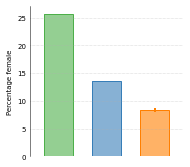

In [8]:
%%time
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(7*cm, 7*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.gca()

plotBars(ax, main, width=0.6, sub=0)
ax.set_ylabel('Percentage female')
ax.set_ylim(0, 0.27)
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.20, 0.25])
ax.set_yticklabels([0, 5, 10, 15, 20, 25])

plt.savefig('../figures/fig_4_a.pdf', bbox_inches = 'tight', pad_inches = 0)

## b

In [9]:
def calcCI(p, n):
    p=p/100
    return np.sqrt(p*(1-p)/n)*scipy.stats.t.ppf((1+0.95)/2., n-1)

In [10]:
def computeTrend(fr, field=None, col='Year', colMin=1970, colMax=2018):
    # col: the column to get percentage; could be Year, or Decade etc.
    
    if field is not None:
        fr = fr[fr.Field == field]
    
    total = fr.groupby(col).Count.sum().reset_index()
    female = fr.groupby([col, 'gender']).Count.sum().reset_index().rename(columns={'Count':'Fcount'})
    female = female[female.gender == 'female']
    
    total = total.merge(female, on=col, how='left')
    total = total.assign(Percent = total.Fcount/total.Count*100)
    
    df = pd.DataFrame({col: [x for x in range(colMin, colMax+1)]})    
    df = df.merge(total, on=col, how='left').fillna(0).sort_values(by=col)
    
    return (df[col].values, df.Percent.values, df.Count.values)

In [11]:
def plotTrend(ax, x, y, n, color='green', lw=1):
    ax.plot(x, y, color=color, lw=lw)
    
    ci = [calcCI(y[i], n[i])*100 for i in range(len(x))]
    lo = [y[i]-ci[i] for i in range(len(x))]
    hi = [y[i]+ci[i] for i in range(len(x))]
    
    ax.fill_between(x, lo, hi, color=color, alpha=0.1)
    
def plotTemporal(ax, xy, lw=1):
    # xy: [(x, p, n)]
    
    plotTrend(ax, xy[0][0], xy[0][1], xy[0][2], colors[0], lw)
    plotTrend(ax, xy[1][0], xy[1][1], xy[1][2], colors[1], lw)
    plotTrend(ax, xy[2][0], xy[2][1], xy[2][2], colors[2], lw)
    
    ax.set_xlim(1970, 2018)
    ax.set_ylim(0, 1)
    
    ax.set_xticks([1970, 1980, 1990, 2000, 2010])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.grid(b=True, ls=':')
    ax.tick_params(length=0)

In [12]:
%%time
maintrend = [computeTrend(df) for df in dfs]

CPU times: user 30.9 ms, sys: 3.02 ms, total: 33.9 ms
Wall time: 34.1 ms


CPU times: user 193 ms, sys: 11.6 ms, total: 204 ms
Wall time: 207 ms


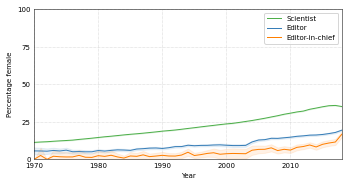

In [13]:
%%time
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(14*cm, 7*cm))
plt.rcParams.update({'font.size': 7})

lines = [Line2D([0], [0], color=colors[0], lw=1),
        Line2D([0], [0], color=colors[1], lw=1),
        Line2D([0], [0], color=colors[2], lw=1)]

#######
ax = plt.gca()
plotTemporal(ax, maintrend)
ax.set_ylabel('Percentage female')
ax.set_xlabel('Year')
ax.legend(lines, ['Scientist', 'Editor', 'Editor-in-chief'])

plt.savefig('../figures/fig_4_b.pdf', bbox_inches = 'tight', pad_inches = 0)

## c

In [14]:
def getDecadeMarker(x):
    if x == 197: return '^'
    elif x == 198: return 's'
    elif x == 199: return 'X'
    elif x == 200: return '*'
    elif x == 201: return 'o'
    else:
        print(f"Decade error {x}")
        
def getDecadeColor(x):
    if x == 197: return '#e41a1c'
    elif x == 198: return '#377eb8'
    elif x == 199: return '#4daf4a'
    elif x == 200: return '#984ea3'
    elif x == 201: return '#ff7f00'
    else:
        print(f"Decade error {x}")

In [15]:
def getPercentDecade(df):
    df = df.assign(decade = df.Year.apply(lambda x: int(x/10)))
    
    df_field = df.groupby(['Field','decade']).Count.sum().reset_index()
    
    df_female = df[df.gender == 'female'].groupby(['Field','decade']).Count.sum().reset_index().rename(
        columns={'Count':'Female'})
    
    df_field = df_field.merge(df_female, on=['Field','decade'], how='left').fillna(0)
    df_field = df_field.assign(percent = df_field.Female/df_field.Count)
    
    return df_field

In [16]:
def plotScatterDecade(df, ax, y, markersize=30, fontsize=7):
    
    df = df.assign(marker = df.decade.apply(lambda x: getDecadeMarker(x)))
    df = df.assign(color = df.decade.apply(lambda x: getDecadeColor(x)))
    
    
    for ind, row in df.iterrows():
        ax.scatter(x=row.Apercent, y=row[y], s=markersize, marker=row.marker, color=row.color, clip_on=False)
        
    ax.plot([x/100 for x in range(75)], [x/100 for x in range(75)], color='black', lw=0.5)
    
    ax.set_xlim(0, 0.7)
    ax.set_ylim(0, 0.73)
    
    ax.set_xticks([0, 0.2, 0.4, 0.6])
    ax.set_xticklabels([0, 20, 40, 60])
    
    ax.set_yticks([0, 0.2, 0.4, 0.6])
    ax.set_yticklabels([0, 20, 40, 60])   

In [17]:
%%time
chief_decade = getPercentDecade(eic).rename(columns={'percent':'Cpercent'})
print(chief_decade.shape)

edi_decade = getPercentDecade(editors).rename(columns={'percent':'Epercent'})
print(edi_decade.shape)

aut_decade = getPercentDecade(authors).rename(columns={'percent':'Apercent'})
print(aut_decade.shape)

decades = [197, 198, 199, 200, 201]

chief_decade = chief_decade[chief_decade.decade.isin(decades)]
edi_decade = edi_decade[edi_decade.decade.isin(decades)]
aut_decade = aut_decade[aut_decade.decade.isin(decades)]

print(aut_decade.shape, edi_decade.shape, chief_decade.shape)

# (90, 6)
# (114, 6)
# (418, 6)
# (95, 6) (79, 6) (76, 6)

(90, 5)
(114, 5)
(418, 5)
(95, 5) (79, 5) (76, 5)
CPU times: user 43.9 ms, sys: 1.81 ms, total: 45.7 ms
Wall time: 45.6 ms


In [18]:
top_fields = pd.read_csv('/scratch/fl1092/capstone/temp/EditorCountIndividualClassifier.csv',
                         sep='\t',usecols=['Field']).head(15).sort_values(by='Field')

In [19]:
edi_plot = top_fields.merge(
    edi_decade[['Field','decade','Epercent']], on=['Field']).merge(
    aut_decade[['Field','decade','Apercent']], on=['Field','decade'])

chief_plot = top_fields.merge(
    chief_decade[['Field','decade','Cpercent']], on='Field').merge(
    aut_decade[['Field','decade','Apercent']], on=['Field','decade'])

print(edi_plot.shape, chief_plot.shape) # (74, 5) (73, 5)

(74, 4) (73, 4)


In [20]:
top_fields = top_fields.sort_values(by='Field').reset_index(drop=True)

Biology
8.89 7.06 8.95 13.99 18.48
18.82 23.53 29.94 36.55 41.4
Business
6.82 7.22 6.26 13.18 21.22
7.68 12.53 18.5 25.53 34.27
Chemistry
1.69 3.54 5.58 5.18 8.37
8.84 12.27 16.47 21.72 27.85
Computer science
2.34 3.33 5.7 7.75 13.36
9.44 10.78 11.95 14.35 20.37
Economics
7.37 6.41 7.15 10.84 17.28
9.52 13.24 19.22 26.71 33.25
Engineering
0.0 1.7 2.57 4.92 8.27
2.68 3.62 4.57 6.6 10.76
Geology
11.4 7.34 9.52 10.27 12.25
6.2 9.77 13.27 18.57 23.64
Materials science
0.33 3.0 3.53 2.72 7.03
3.34 4.96 6.23 9.06 14.12
Mathematics
2.72 3.41 4.52 4.72 8.46
6.38 8.65 11.44 15.52 20.96
Medicine
7.24 12.98 14.47 18.59 18.86
15.14 20.19 26.1 33.79 40.89
Philosophy
13.33 22.51 31.23 30.67 42.29
15.26 20.82 27.41 34.56 41.99
Physics
2.44 2.72 3.92 4.49 6.9
6.27 7.66 9.43 12.16 16.17
Political science
3.68 15.83 18.91 22.62 25.04
15.04 21.02 28.2 36.07 43.89
Psychology
8.39 11.75 17.98 26.27 34.4
24.08 33.17 41.9 49.14 55.35
Sociology
33.33 52.28 64.78 53.06
29.8 41.08 50.09 55.98
CPU times: user 1.

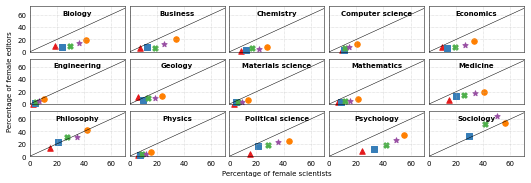

In [21]:
%%time
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(22.5*cm, 7*cm))
plt.rcParams.update({'font.size': 7})
GS = gridspec.GridSpec(3, 5, wspace=0.05, hspace=0.15)

axes = [plt.subplot(GS[int(x/5), x%5]) for x in range(15)]

for ind, row in top_fields.iterrows():
    field = row['Field']
    ax = axes[ind]
    print(field)
    print(' '.join([str(round(x*100, 2)) for x in edi_plot[edi_plot.Field == field].Epercent]))
    print(' '.join([str(round(x*100, 2)) for x in edi_plot[edi_plot.Field == field].Apercent]))
          

    plotScatterDecade(edi_plot[edi_plot.Field == field], ax, 'Epercent')
    ax.text(0.5, 0.8, ha = 'center', s=field, fontsize=7, fontweight='bold', transform=ax.transAxes)
    
    ax.grid(b=True, ls=':')
    ax.tick_params(length=0)
    
for ind in [5]:
    axes[ind].set_ylabel('Percentage of female editors')
for ind in [12]:
    axes[ind].set_xlabel('Percentage of female scientists')
    
for ind in range(15):
    if ind not in [0, 5, 10]:
        axes[ind].set_yticklabels([])
    
for ind in range(15):
    if ind not in [10, 11, 12, 13, 14]:
        axes[ind].set_xticklabels([])

plt.savefig("../figures/fig_4_c.pdf", bbox_inches = 'tight', pad_inches = 0)

## d

In [22]:
def plotLengthScatter(df, ax, markersize=10, color='grey'):
    df = df.groupby(['Field', 'gender']).length.mean().reset_index()
    df = df.merge(top_fields, on='Field')
    
    male = df[df.gender=='male'].rename(columns={'length':'male'})
    female = df[df.gender=='female'].rename(columns={'length':'female'})
    
    df = male.merge(female, on='Field')
    print(df.shape)
    
    ax.plot([x for x in range(11)], [x for x in range(11)], color='black', lw=0.5)
    
    below = df[df.male > df.female]
    ax.scatter(x=below.male, y=below.female, s=markersize, marker='o', color='grey')
    
    above = df[df.male <= df.female]
    ax.scatter(x=above.male, y=above.female, s=markersize, marker='o', color='red')
    
    
    for ind, row in below.iterrows():
        if row['Field'] == 'Geology':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(2.9, 2.6), textcoords='data',
                arrowprops=dict(arrowstyle="-", linewidth=0.3,shrinkA=0,connectionstyle="arc3,rad=.2"))
            
        if row['Field'] == 'Medicine':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(3.3, 2), textcoords='data',
                arrowprops=dict(arrowstyle="-", linewidth=0.3,shrinkA=0,relpos=(0.8,0.5), connectionstyle="arc3,rad=.1"))
            
        if row['Field'] == 'Materials science':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(3.5, 1.5), textcoords='data',
                arrowprops=dict(arrowstyle="-", linewidth=0.3,shrinkA=0, connectionstyle="arc3,rad=0"))
            
        if row['Field'] == 'Computer science':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(6, 1.8), textcoords='data',
                arrowprops=dict(arrowstyle="-",relpos=(0,0.5),shrinkA=0, linewidth=0.3,
                                connectionstyle="arc3,rad=-.2"))
            
        if row['Field'] == 'Chemistry':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(5.8, 2.2), textcoords='data',
                arrowprops=dict(arrowstyle="-", linewidth=0.3, relpos=(0.0,0.5), shrinkA=0,connectionstyle="arc3,rad=-.2"))
            
        if row['Field'] == 'Physics':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(6, 2.6), textcoords='data',
                arrowprops=dict(arrowstyle="-", linewidth=0.3, shrinkA=0,relpos=(0,0.5),connectionstyle="arc3,rad=-.1"))
            
        if row['Field'] == 'Engineering':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(6.2, 3), textcoords='data',
                arrowprops=dict(arrowstyle="-", linewidth=0.3,shrinkA=0,relpos=(0,0.5), connectionstyle="arc3,rad=-.2"))
            
        if row['Field'] == 'Biology':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(6.4, 3.4), textcoords='data',
                arrowprops=dict(arrowstyle="-",linewidth=0.3,shrinkA=0,relpos=(0.1,0.5),connectionstyle="arc3,rad=0.1"))
            
        if row['Field'] == 'Psychology':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(6.4, 3.8), textcoords='data',
                arrowprops=dict(arrowstyle="-",linewidth=0.3,shrinkA=0,relpos=(0.1,0.5),connectionstyle="arc3,rad=0.1"))
        
        if row['Field'] == 'Political science':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(6.6, 4.2), textcoords='data',
                arrowprops=dict(arrowstyle="-",linewidth=0.3,shrinkA=0,relpos=(0,0.5),connectionstyle="arc3,rad=-0.1"))
            
        if row['Field'] == 'Mathematics':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(7, 4.6), textcoords='data',
                arrowprops=dict(arrowstyle="-",linewidth=0.3,shrinkA=0,relpos=(0,0.5),connectionstyle="arc3,rad=0.1"))
            
        if row['Field'] == 'Philosophy':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(7, 5), textcoords='data',
                arrowprops=dict(arrowstyle="-",linewidth=0.3,shrinkA=0,relpos=(0,0.5),connectionstyle="arc3,rad=0"))
            
        if row['Field'] == 'Economics':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(7.2, 5.4), textcoords='data',
                arrowprops=dict(arrowstyle="-",linewidth=0.3,shrinkA=0,relpos=(0,0.5),connectionstyle="arc3,rad=-0.2"))
            
        if row['Field'] == 'Business':
            ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,
                xytext=(6.6, 5.8), textcoords='data')
        
    for ind, row in above.iterrows():
        ax.annotate(row['Field'], xy=(row['male'],row['female']), xycoords='data',fontsize=6,color='red',
                xytext=(5, 7), textcoords='data')
        
    return df

In [23]:
editor_length = pd.read_csv('../data/figure_4/EditorCareerLength.csv',sep='\t',
                      dtype={'gender':str,'Field':str,'length':int}, usecols=['gender','Field','length'])
editor_length.shape

(80926, 3)

(15, 5)


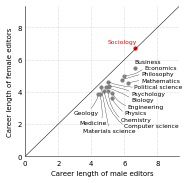

In [24]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(7*cm, 7*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.gca()

plotLengthScatter(editor_length, ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Career length of male editors')
ax.set_ylabel('Career length of female editors')

ax.set_xlim(0, 9.3)
ax.set_ylim(0, 9.3)
ax.grid(b=True, ls=':')
ax.tick_params(length=0)

plt.savefig('../figures/fig_4_d.pdf',bbox_inches = 'tight', pad_inches = 0)

### inset

In [25]:
def computeBar(df, col, values, cat=None):
    # values: [female, male]
    if cat:
        df = df[df.Category == cat]
        print(df.shape)
        
    return [df[df[col] == values[0]].length, df[df[col] == values[1]].length]

In [26]:
def plotTwoBars(ax, a, color, width=0.4, sub=True):
    # a: ([values .... ], [values .... ])
    col = [color, color]
    barCol = ['white', color]
    
    means = [x.mean() for x in a]
    errs = [scipy.stats.sem(x)*scipy.stats.t.ppf((1+0.95)/2., len(x)-1) for x in a]
    
    bars = plt.bar([1.5,1], means, width=width, color=barCol, alpha=0.8,
            yerr=errs, ecolor=col, edgecolor=col, linewidth=0.2,
            error_kw={'elinewidth':0.5})
    
    bars[0].set_hatch('///////')
    
    pfont=5 if sub else 7
    
    pVal = scipy.stats.ttest_ind(a[1], a[0]).pvalue
    plotPvalue(ax, [1, 1.5], [means[1] + errs[1], means[0] + errs[0]], pVal, scale=5, fontsize=pfont)
    
    ax.set_xticks([])
    ax.spines['right'].set_visible(False)
    
    ax.grid(b=True, ls=':', axis='y')
    ax.tick_params(length=0)
    ax.set_xticklabels([])
    
    if sub:
        ax.set_ylim(0, 10)
        ax.set_yticks([0, 2, 4, 6, 8])
        ax.set_yticklabels([0, 2, 4, 6, 8], fontdict={'fontsize':5})
        
        if sub==1:
            ax.spines['top'].set_visible(False)
        if sub==3:
            ax.spines['bottom'].set_visible(False)
    else:
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)

In [27]:
ebar = computeBar(editor_length, 'gender', ['male','female'])

CPU times: user 101 ms, sys: 3.89 ms, total: 105 ms
Wall time: 107 ms


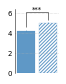

In [28]:
%%time
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(2*cm, 3*cm))
plt.rcParams.update({'font.size': 7})

ax = plt.gca()
plotTwoBars(ax, ebar, colors[1], sub=0)

plt.savefig('../figures/fig_4_d_inset.pdf',bbox_inches = 'tight', pad_inches = 0)

## e

In [29]:
def computeTrend(fr, cat=None, field=None, col='Year', colMin=1970, colMax=2018):
    # col: the column to get percentage; could be Year, or Decade etc.
    
    if cat is not None:
        fr = fr[fr.Category==cat]
        
    if field is not None:
        fr = fr[fr.Field == field]
        
    fr = fr.assign(Count = 1)
    
    total = fr.groupby(col).Count.count().reset_index()
    female = fr.groupby([col, 'gender']).Count.count().reset_index().rename(columns={'Count':'Fcount'})
    female = female[female.gender == 'female']
    
    total = total.merge(female, on=col, how='left')
    total = total.assign(Percent = total.Fcount/total.Count*100)
    
    df = pd.DataFrame({col: [x for x in range(colMin, colMax+1)]})    
    df = df.merge(total, on=col, how='left').fillna(0).sort_values(by=col)
    
    return (df[col].values, df.Percent.values, df.Count.values)

In [30]:
def mean(a):
    return sum(a)/len(a)

def caclCIValues(a, conf=0.95):
    sem, m = scipy.stats.sem(a), scipy.stats.t.ppf((1+conf)/2., len(a)-1)
    return m*sem

def plotTrend(ax, x, y, n, color='green', lw=2, alpha=1):
    ax.plot(x, y, color=color, lw=lw, alpha=alpha)
    
    ci = [calcCI(y[i], n[i])*100 for i in range(len(x))]
    lo = [y[i]-ci[i] for i in range(len(x))]
    hi = [y[i]+ci[i] for i in range(len(x))]
    
    ax.fill_between(x, lo, hi, color=color, alpha=0.1)
    
def plotTemporal(ax, xy, colors, lw=1):
    # xy: [(x, p, n)]
    alphas=[1, 1]
    
    plotTrend(ax, xy[0][0], xy[0][1], xy[0][2], colors[0], lw, alpha=alphas[0])
    plotAggTrend(ax, xy[1], colors[1], lw, alpha=alphas[1])

def plotAggTrend(ax, trends, color='green', lw=2, alpha=1):
    x = trends[0][0]
    ys = [[trends[seed][1][year] for seed in range(50)] for year in range(len(trends[0][1]))]
    
    means = [mean(l) for l in ys]
    ci = [caclCIValues(l) for l in ys]
    
    
    print(len(ys), len(means))
    
    lo = [means[i]-ci[i] for i in range(len(x))]
    hi = [means[i]+ci[i] for i in range(len(x))]
    
    ax.plot(x, means, color=color, lw=lw, alpha=alpha)
    ax.fill_between(x, lo, hi, color=color, alpha=0.1)

In [31]:
etrends = []
for seed in range(50):
    sampled_range = pd.read_csv(f'../data/figure_4/randomBaseline/editorSampleAgeCitePub/{seed}.csv',sep='\t',
                          usecols=['Year','Field','gender'],
                     dtype={'Year':int,'Field':str,'gender':str})
    sampled_trend = computeTrend(sampled_range)
    
    etrends.append(sampled_trend)

In [32]:
editor_range = pd.read_csv('../data/figure_4/randomBaseline/Editors.csv',sep='\t',
                           dtype={'gender':str,'Field':str,'Year':int})
print(editor_range.shape)

editor_trend = computeTrend(editor_range)

(396991, 3)


In [33]:
chief_range = pd.read_csv('../data/figure_4/randomBaseline/EICs.csv',sep='\t',
                           dtype={'gender':str,'Field':str,'Year':int})
print(chief_range.shape)

chief_trend = computeTrend(chief_range)

(17687, 3)


In [34]:
ctrends = []
for seed in range(50):
    sampled_range = pd.read_csv(f'../data/figure_4/randomBaseline/eicSampleAgeCitePub/{seed}.csv',sep='\t',
                          usecols=['Year','Field','gender'],
                     dtype={'Year':int,'Field':str,'gender':str})
    
    sampled_trend = computeTrend(sampled_range)
    
    ctrends.append(sampled_trend)

In [35]:
def plotChief(ax):
    maintrend = [chief_trend, ctrends]
    colors = ['#ff7f00', '#984ea3', '#e41a1c']
    
    plotTemporal(ax, maintrend, colors)
    ax.set_ylabel('Percentage female')
    ax.set_xlabel('Year')

    ax.set_xlim(1970, 2018)
    ax.set_ylim(0, 0.25)

    ax.set_xticks([1970, 1980, 1990, 2000, 2010])
    ax.set_yticks([0, 5, 10, 15, 20, 25])
    ax.grid(b=True, ls=':')
    ax.tick_params(length=0)

    lines = [
            Line2D([0], [0], color=colors[0], lw=1),
            Line2D([0], [0], color=colors[1], lw=1)]
    ax.legend(lines, ['Editor-in-chief (real)', 'Editor-in-chief (randomized)'], loc='upper left')

In [36]:
def plotEditor(ax):
    maintrend = [editor_trend, etrends]
    colors = ['#377eb8', '#984ea3', '#e41a1c'] # '#4daf4a', 


    plotTemporal(ax, maintrend, colors)
    ax.set_ylabel('Percentage female')
    ax.set_xlabel('Year')

    ax.set_xlim(1970, 2018)
    ax.set_ylim(0, 0.25)

    ax.set_xticks([1970, 1980, 1990, 2000, 2010])
    ax.set_yticks([0, 5, 10, 15, 20, 25])
    ax.grid(b=True, ls=':')
    ax.tick_params(length=0)

    lines = [
            Line2D([0], [0], color=colors[0], lw=1),
            Line2D([0], [0], color=colors[1], lw=1)]
    ax.legend(lines, ['Editor (real)', 'Editor (randomized)'], loc='upper left')

49 49
49 49


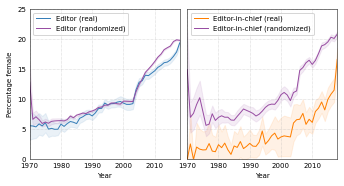

In [37]:
plt.figure(figsize=(14*cm, 7*cm))

GS = gridspec.GridSpec(1, 2, wspace=0.05)

###############################
ax = plt.subplot(GS[0:1, 0:1])
plotEditor(ax)

ax = plt.subplot(GS[0:1, 1:2])
plotChief(ax)
ax.set_yticklabels([])
ax.set_ylabel('')

plt.savefig('../figures/fig_4_e.pdf', bbox_inches = 'tight', pad_inches = 0)